In [87]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm

In [96]:
def theFunc(u):
    return 8*u[0]*u[1]*u[2]

def truePDF(y):
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output

def conditionalDensity1(y, x2, x3):
    test = y / (x2*x3)
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y

def conditionalDensity2(y, x1, x3):
    test = y / (x1*x3)
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)

def conditionalDensity3(y, x1, x2):
    test = y / (x1*x2)
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

def kernelDensityEstimator(y, pointSet, bandwidth): 
    n = len(pointSet)
    def gaussianKernel(z):
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator(y, condDensity, realizations1, realizations2):
    if len(realizations1) != len(realizations2):
        raise Exception("realizations are of different size")
    else:
        output = 0
        n = len(realizations1)
        for j in range(n):
            output += condDensity(y, realizations1[j], realizations2[j]) / n
        return output
    


In [94]:
start, end = 0.01, 8
nError = 100


def getErrorofThreeVariables(pointSetType, n, method, bandwidth):
    errorPoints = np.linspace(start, end, nError)

    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(3).gen_samples(n)
    elif pointSetType == "Sobol":
        pointSet = qp.Sobol(3).gen_samples(n)
    else:
        raise Exception("Currently supported pointSetTypes are MC and Sobol")
    
    if method == "KDE":
        evaluatedPoints = kernelDensityEstimator(errorPoints, pointSet, bandwidth)
    elif method == "hiding1" or method == "hiding2" or method == "hiding3":
        realizations1 = inverseCDF1(pointSet[:, 0])
        realizations2 = inverseCDF2(pointSet[:, 1])
        realizations3 = inverseCDF3(pointSet[:, 2])
        if method == "hiding1":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity1, realizations2, realizations3)
        if method == "hiding2":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity2, realizations1, realizations3)
        if method == "hiding3":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity3, realizations1, realizations2)
    else:
        raise Exception("Valid methods are KDE or hiding#")
    
    estimatedError = ((end - start) / nError) * np.sum((evaluatedPoints - truePDF(errorPoints))**2)
    return estimatedError

def averageErrorLog(pointSetType, n, method, averageAcross, bandwidth):
    sum = 0
    for i in range(averageAcross):
        sum += (1 / averageAcross) * getErrorofThreeVariables(pointSetType, n, method, bandwidth)
    return -np.log10(sum)

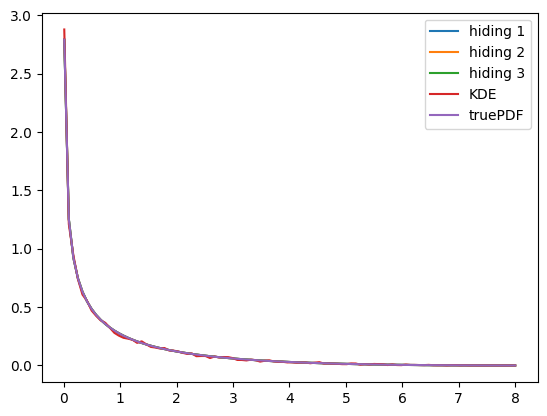

In [97]:
n = 2**16
nEval = 100
evalPoints = np.linspace(0.01, 8, nEval)
fig, ax = plt.subplots()

sobolPoints = qp.Sobol(3).gen_samples(n)
realizations1 = inverseCDF1(sobolPoints[:, 0])
realizations2 = inverseCDF2(sobolPoints[:, 1])
realizations3 = inverseCDF3(sobolPoints[:, 2])

truePoints = truePDF(evalPoints)

hiding1Points = conditionalEstimator(evalPoints, conditionalDensity1, realizations2, realizations3)
hiding2Points = conditionalEstimator(evalPoints, conditionalDensity2, realizations1, realizations3)
hiding3Points = conditionalEstimator(evalPoints, conditionalDensity3, realizations1, realizations2)

const = 0.0602758320635
bandwidth = const * n**(-1/5)
KDEPoints = kernelDensityEstimator(evalPoints, sobolPoints, bandwidth)


ax.plot(evalPoints, hiding1Points, label = "hiding 1")
ax.plot(evalPoints, hiding2Points, label = "hiding 2")
ax.plot(evalPoints, hiding3Points, label = "hiding 3")
ax.plot(evalPoints, KDEPoints, label = "KDE")
ax.plot(evalPoints, truePoints, label = "truePDF")
legend = ax.legend()

In [98]:
const = 0.0602758320635
for method in ["hiding1", "hiding2", "hiding3", "KDE"]:
    for exp in range(10, 17, 2):
        n = 2**exp
        bandwidth = const * n**(-1/5)
        print(exp, method, averageErrorLog("Sobol", n, method, 10, bandwidth))

10 hiding1 2.89531575025803
12 hiding1 3.8876161268064777
14 hiding1 4.774803485960834
16 hiding1 5.68766394058581
10 hiding2 2.851589873389273
12 hiding2 3.7312138641836325
14 hiding2 4.654745832018776


KeyboardInterrupt: 